# Secure Variant Testing

In [1]:
import tensorflow as tf
import os
cwd = os.getcwd()
os.chdir('../../src/')
from dataloader import OneHotEncoder, load_fasta_data, RNASeqDataGenerator
os.chdir('../experiments/CrossValidation/')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [3]:
from scipy import stats
from tqdm import tqdm
import numpy as np
import tensorflow as tf

be_type = 'CBE'
be_class = 'A3A'
sample = '160G'
    
data_dir = "../../data/raw/{0}/{0}-sequence/".format(be_type)

train_chr = [str(x) for x in range(1, 23)]+['X']

train_seqs, train_ers = [], []
for rep in tqdm(train_chr):
        seq, er = load_fasta_data(sample, rep, data_dir)
        train_seqs = seq+train_seqs
        train_ers = er+train_ers

100%|██████████| 23/23 [00:05<00:00,  4.09it/s]


In [5]:
model = tf.keras.models.load_model("../CrossValidation/A3A/160FFold-1.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
ohe = OneHotEncoder(101, {'A':0, 'C':1, 'G':2, 'T':3})

In [18]:
inp = np.stack([ohe.encode(x) for x in tqdm(train_seqs)])

100%|██████████| 1815207/1815207 [00:58<00:00, 31075.45it/s]


In [19]:
inp.shape

(1815207, 101, 4)

In [20]:
preds = model.predict(inp)

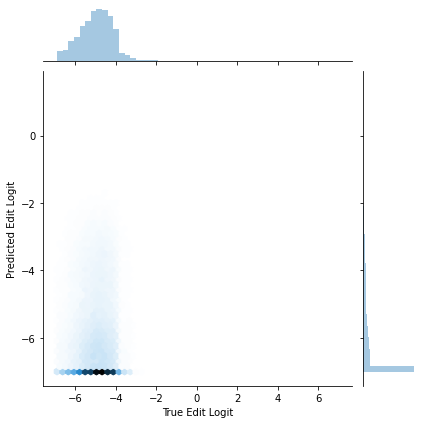

In [49]:
import pandas as pd
import seaborn as sns
def logit_transform(x):
    if x < 1/(1+np.exp(7)):
         return -7
    if x>1/(1+np.exp(-7)):
          return 7
    return np.log(x/(1-x))

df = pd.DataFrame({'Predicted Edit Logit': [logit_transform(x) for x in np.squeeze(preds, axis=1)], 'True Edit Logit':[logit_transform(x) for x in train_ers]})
df.drop(df.index[df['True Edit Logit'] == -7], inplace = True)
#df.drop(df.index[df['Predicted Edit Logit'] == -7], inplace = True)
sns.jointplot('True Edit Logit', 'Predicted Edit Logit', df, kind='hex')

In [50]:
from scipy import stats

stats.spearmanr(df['True Edit Logit'], df['Predicted Edit Logit'])[0]
#stats.pearsonr(df['True Edit Logit'], df['Predicted Edit Logit'])[0]

0.018660373853788777